In [11]:
import pandas as pd
import os
from fastai.tabular.all import *
import matplotlib.pyplot as plt

# When the data analysis should stop
LAST_DAY = pd.Timestamp("2024-04-10")

In [27]:
def get_csv(url, local_filename):
    if not os.path.exists(local_filename):
        print(f"{local_filename} not found locally. Downloading and reading from URL...")
        df = pd.read_csv(url)
        df.to_csv(local_filename, index=False)  # Save the downloaded file locally
    else:
        print(f"Reading {local_filename} from local storage...")
        df = pd.read_csv(local_filename)
    return df

# Temp data exploration

- [Glossary](https://climate.weather.gc.ca/glossary_e.html)

In [277]:
temp_df = pd.concat([pd.read_csv("./2022_temp.csv"), pd.read_csv("./2023_temp.csv"), pd.read_csv("./2024_temp.csv")])
temp_df = temp_df[['Mean Temp (°C)', "Date/Time", "Total Precip (mm)"]]

temp_df['date'] = pd.to_datetime(temp_df['Date/Time'])
temp_df['date'] = temp_df['date'].dt.date

temp_df.rename(columns={"Mean Temp (°C)": "mean_temp", "Total Precip (mm)": "total_precip"}, inplace=True)
temp_df.drop("Date/Time", inplace=True, axis=1)

temp_df.fillna({"mean_temp": temp_df.mode()['mean_temp'][0], "total_precip": 0}, inplace=True)

temp_df

,mean_temp,total_precip,date
0,-0.6,2.4,2022-01-01
1,-8.7,5.0,2022-01-02
2,-17.0,0.0,2022-01-03
3,-10.3,0.0,2022-01-04
4,-2.6,0.8,2022-01-05
...,...,...,...
361,22.3,0.0,2024-12-27
362,22.3,0.0,2024-12-28
363,22.3,0.0,2024-12-29
364,22.3,0.0,2024-12-30


# AQI data exploration

### The accuracy is shit so here some things to try:
- [ ] External data
- [ ] Different date feature engineering approach
- [ ] Remove/leave pollutant
- [ ] Model ensembling
- [x] Use random forests


Compare results with https://aqicn.org/city/montreal/

In [252]:
df1 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/0c325562-e742-4e8e-8c36-971f3c9e58cd/download/rsqa-indice-qualite-air-2022-2024.csv', '2022-2024.csv')
# df2 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/e43dc1d6-fbdd-49c3-a79f-83f63404c281/download/rsqa-indice-qualite-air-2019-2021.csv', '2019-2021.csv')
# df3 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/93a3a88e-97ab-4ab1-813f-5419a1dd330d/download/rsqa-indice-qualite-air-2016-2018.csv", "2016-2018.csv")
# df4 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/02cfaf0c-3b46-4dac-bf66-acd2ff47361a/download/rsqa-indice-qualite-air-2013-2015.csv", "2013-2015.csv")
# df5 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/6e59c6e9-749b-4237-9c45-5c627be2b7ad/download/rsqa-indice-qualite-air-2010-2012.csv", "2010-2012.csv")

Reading 2022-2024.csv from local storage...


In [253]:
# df = pd.concat([df1, df2, df3, df4, df5])
df = df1

In [254]:
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['heure'].astype(str) + ':00:00',
                                format = '%Y-%m-%d %H:%M:%S',
                                errors = 'coerce')
df.drop(["heure", "polluant", "date"], axis=1, inplace=True)
df.sort_values("datetime", inplace=True)

df['year'] = df['datetime'].dt.year

# Year has a bigger number range than the rest so we divide it up by its maximum
df['year'] = df['year'] / df['year'].max()
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday
df['hour'] = df['datetime'].dt.hour

# Taking a sample of data for a given datetime and station id
df[(df["stationId"] == 103) & (df["datetime"] == "2024-04-15 19:00:00")]

,stationId,valeur,datetime,year,month,day,weekday,hour
769468,103,24,2024-04-15 19:00:00,1.0,4,15,0,19
769470,103,5,2024-04-15 19:00:00,1.0,4,15,0,19
769469,103,2,2024-04-15 19:00:00,1.0,4,15,0,19


In [251]:
# the data contains measurements across various stations (spread over the MTL territory).
# We can take the maximum measurement for a given station for a given datetime (regardless of the pollutant).
# Note: we are assuming each pollutant contributes equally to the AQI level
# (Using the maximum pollutant value as a representative AQI is simplistic. Real AQI calculation may involve more complex computations where different pollutants have different weights or scale adjustments based on their health impact.)
group1_df = df.groupby(['stationId', 'datetime']).max("valeur")

# Manually verifying the maximum has been taken for a given station id on a given datetime
group1_df.loc[(103, "2024-04-15 19:00:00")]

valeur     24.0
year        1.0
month       4.0
day        15.0
weekday     0.0
hour       19.0
Name: (103, 2024-04-15 19:00:00), dtype: float64

In [255]:
first_day = pd.Timestamp("2024-01-01")

# Get the mean across all station maximums for each datetime
group2_df = group1_df.groupby("datetime").mean("valeur")

# Manually verifying the mean of a give datetime across all stations
# group2_df.loc["2024-04-15 19:00:00"], group1_df.xs("2024-04-15 19:00:00", level='datetime')
group2_df['date'] = group2_df.index.date
group2_df.reset_index(inplace=True)


# TODO: we need to filter out for only data that's witin the temp_df range, otherwise it'll be filled with NaN
filtered = group2_df.loc[(group2_df['datetime'] >= first_day) & (group2_df['datetime'] <= LAST_DAY)]

merged = pd.merge(filtered, temp_df, on="date", how="left")

merged[merged['datetime'] > pd.Timestamp("2024-04-08 01:00:00")]

,datetime,valeur,year,month,day,weekday,hour,date,mean_temp,total_precip
2354,2024-04-08 02:00:00,14.363636,1.0,4.0,8.0,0.0,2.0,2024-04-08,10.0,0.0
2355,2024-04-08 03:00:00,12.909091,1.0,4.0,8.0,0.0,3.0,2024-04-08,10.0,0.0
2356,2024-04-08 04:00:00,12.636364,1.0,4.0,8.0,0.0,4.0,2024-04-08,10.0,0.0
2357,2024-04-08 05:00:00,12.818182,1.0,4.0,8.0,0.0,5.0,2024-04-08,10.0,0.0
2358,2024-04-08 06:00:00,11.545455,1.0,4.0,8.0,0.0,6.0,2024-04-08,10.0,0.0
2359,2024-04-08 07:00:00,12.545455,1.0,4.0,8.0,0.0,7.0,2024-04-08,10.0,0.0
2360,2024-04-08 08:00:00,14.545455,1.0,4.0,8.0,0.0,8.0,2024-04-08,10.0,0.0
2361,2024-04-08 09:00:00,16.090909,1.0,4.0,8.0,0.0,9.0,2024-04-08,10.0,0.0
2362,2024-04-08 10:00:00,17.818182,1.0,4.0,8.0,0.0,10.0,2024-04-08,10.0,0.0
2363,2024-04-08 11:00:00,19.636364,1.0,4.0,8.0,0.0,11.0,2024-04-08,10.0,0.0


In [ ]:
split_date_valid = pd.Timestamp('2022-01-01')
split_date_test = pd.Timestamp('2023-01-01')

train_idx = group2_df.index < split_date_valid
valid_idx = (group2_df.index >= split_date_valid) & (group2_df.index < split_date_test)
test_idx = group2_df.index >= split_date_test

train_idxs = np.where(train_idx)[0].tolist()
valid_idxs = np.where(valid_idx)[0].tolist()
test_idxs = np.where(test_idx)[0].tolist()

len(train_idxs), len(valid_idxs)

(105191, 8760)

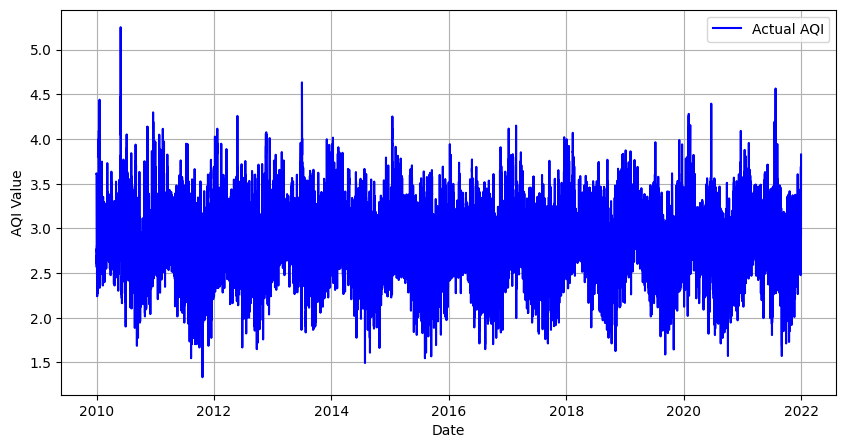

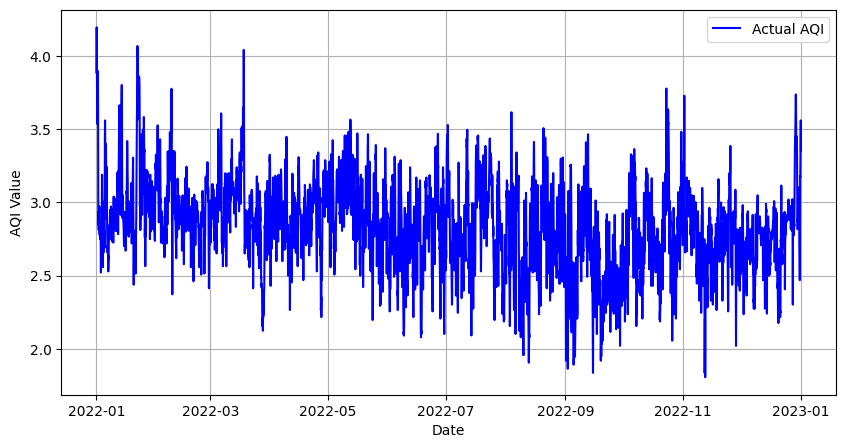

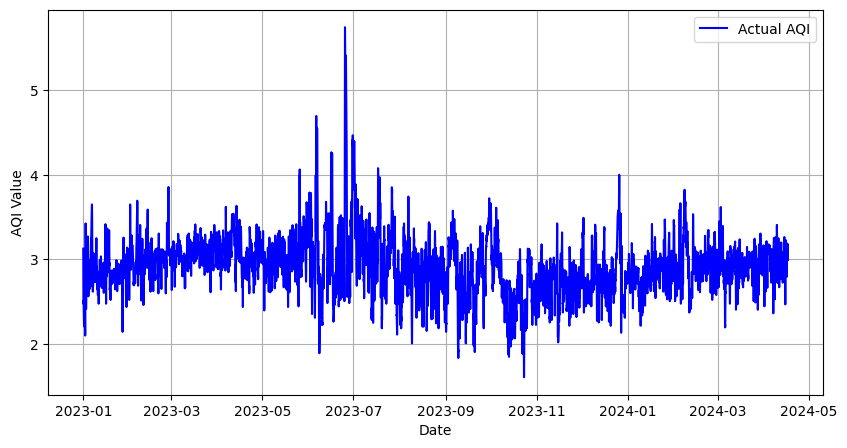

In [ ]:
def plot_aqi(xs):
  plt.figure(figsize=(10, 5))  # Set the figure size for better readability
  plt.plot(xs, label='Actual AQI', color='blue')  # Plot the actual AQI values
  plt.xlabel('Date')  # Label for the x-axis
  plt.ylabel('AQI Value')  # Label for the y-axis
  plt.legend()  # Add a legend to distinguish the lines
  plt.grid(True)  # Add grid for better readability of the plot
  plt.show()  # Display the plot


plot_aqi(group2_df.iloc[train_idxs]['valeur'])
plot_aqi(group2_df.iloc[valid_idxs]['valeur'])
plot_aqi(group2_df.iloc[test_idxs]['valeur'])


In [ ]:
final_df = group2_df.reset_index()
dls = TabularPandas(
  final_df,
  procs=[Normalize],
  cat_names=[],
  cont_names=['year', 'month', 'day', 'weekday', 'hour'],
  y_names=['valeur'],
  splits=(train_idxs, valid_idxs),
  y_block=RegressionBlock()
).dataloaders(500)

dls.show_batch()

,year,month,day,weekday,hour,valeur
0,0.993577,10.0,22.0,5.0,16.0,6.800000
1,0.995059,11.0,4.0,1.0,3.0,16.636364
2,0.993083,6.0,4.0,4.0,14.0,19.799999
3,0.994071,9.0,30.0,6.0,18.0,5.500000
4,0.996542,2.0,12.0,6.0,2.0,18.090910
5,0.995553,2.0,12.0,3.0,18.0,21.272728
6,0.995553,12.0,3.0,3.0,9.0,9.000000
7,0.994071,6.0,17.0,6.0,1.0,27.600000
8,0.993083,12.0,29.0,2.0,12.0,20.200001
9,0.995553,4.0,23.0,3.0,22.0,11.900000


# Neural net impl

In [ ]:
learn = tabular_learner(dls, metrics=mae, layers=[10, 10])

SuggestedLRs(valley=0.05754399299621582, slide=6.309573450380412e-07)

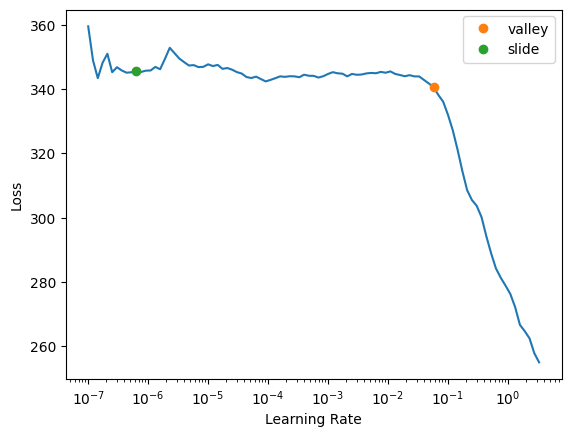

In [ ]:
learn.lr_find(suggest_funcs=[valley, slide])

In [ ]:
learn.fit_one_cycle(10, 0.01)

epoch,train_loss,valid_loss,mae,time
0,299.928894,449.037048,16.664194,00:02
1,48.625828,173.427368,5.292064,00:02
2,39.948868,174.045013,5.294188,00:02
3,38.985142,170.944992,5.231408,00:02
4,38.176941,172.768829,5.263767,00:03
5,38.609249,173.963181,5.264149,00:02
6,38.698681,172.413223,5.210272,00:02
7,37.739323,172.558914,5.233956,00:02
8,39.059719,172.095322,5.235281,00:05
9,38.491859,172.336441,5.228196,00:02


In [ ]:
# learn.recorder.plot_loss()
learn.show_results(max_n=10)

,year,month,day,weekday,hour,valeur,valeur_pred
0,2.236987,1.588154,-0.423818,-1.000857,1.083473,13.909091,15.054518
1,2.236987,-0.441595,-0.196548,1.501285,1.083473,24.818182,17.823792
2,2.236987,1.588154,-0.991994,0.000000,-0.216695,13.636364,13.552986
3,2.236987,1.008225,0.485263,0.500428,0.216695,21.727272,13.715446
4,2.236987,1.008225,0.371628,0.000000,-0.505621,12.727273,13.184334
5,2.236987,-1.311487,-0.082912,-0.500428,0.072232,19.363636,17.568426
6,2.236987,0.718261,0.826169,1.000857,-0.505621,18.181818,12.536079
7,2.236987,1.298190,-1.446535,0.500428,-1.083473,13.363636,12.975909
8,2.236987,-0.731559,1.167074,-0.500428,-0.216695,22.090910,15.794241
9,2.236987,-0.151631,0.826169,0.500428,-0.939010,12.272727,13.397153


# Random forest impl

_RandomForest doesn't seem to offer much better results than using deep learning for this dataset._

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import torch

m = RandomForestRegressor(n_jobs=-1, n_estimators=100,
        max_samples=10_000, max_features=0.5,
        min_samples_leaf=5, oob_score=True).fit(dls.train.xs, dls.train.y)
preds = m.predict(dls.valid.xs)
preds_tensor = torch.tensor(preds)

mae(preds_tensor, torch.tensor(dls.valid.y.values))

TensorBase(3.8998)

# Run test set

In [ ]:
df_test = final_df.loc[test_idxs]
test_dl = dls.test_dl(df_test)

In [ ]:
preds, targets = learn.get_preds(dl=test_dl)

mae(preds, targets)

NameError: name 'learn' is not defined

In [ ]:
preds = torch.tensor(m.predict(test_dl.xs))
mae(preds, torch.tensor(test_dl.y.values))

TensorBase(4.8194)

In [ ]:
# Comparing
# TODO: test data only covers a few months...it would be interesting to see when in the year the model makes worse predictions
df = pd.DataFrame({'datetime': df_test['datetime'],
              'Actual': df_test['valeur'],
              'Predicted': preds.flatten() })

df['Percentage Error'] = np.abs(df['Actual'] - df['Predicted']) / df['Actual'] * 100

df

,datetime,Actual,Predicted,Percentage Error
113951,2023-01-01 00:00:00,21.818182,24.235195,11.077978
113952,2023-01-01 01:00:00,15.909091,23.959288,50.601238
113953,2023-01-01 02:00:00,12.363636,23.588948,90.792964
113954,2023-01-01 03:00:00,10.909091,22.998992,110.824098
113955,2023-01-01 04:00:00,11.363636,22.859006,101.159257
...,...,...,...,...
125274,2024-04-16 19:00:00,22.545455,20.287182,10.016532
125275,2024-04-16 20:00:00,21.181818,19.587965,7.524629
125276,2024-04-16 21:00:00,20.545455,18.433148,10.281137
125277,2024-04-16 22:00:00,19.181818,18.272522,4.740405


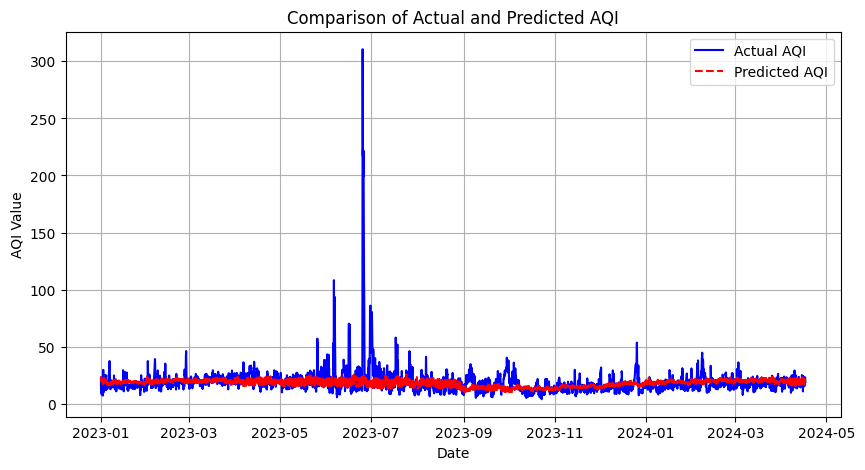

In [ ]:
import matplotlib.pyplot as plt

df = df.set_index('datetime')
# Plotting
plt.figure(figsize=(10, 5))  # Set the figure size for better readability
plt.plot(df['Actual'], label='Actual AQI', color='blue')  # Plot the actual AQI values
plt.plot(df['Predicted'], label='Predicted AQI', color='red', linestyle='--')  # Plot the predicted AQI values with a dashed line
plt.title('Comparison of Actual and Predicted AQI')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('AQI Value')  # Label for the y-axis
plt.legend()  # Add a legend to distinguish the lines
plt.grid(True)  # Add grid for better readability of the plot
plt.show()  # Display the plot